# Import

In [1]:
# Mac에서 torch 다운로드
# pip3 install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu

In [2]:
import gc
gc.collect()

35

In [3]:
import random
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
import numpy as np
import os
import glob

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset

from tqdm.auto import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fp = fm.FontProperties(fname='/home/studio-lab-user/Dacon/tools/NanumFont/NanumGothic.ttf', size=10)
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [4]:
# # cuda (not Mac)
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# # mps (Mac)
# device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')

device = torch.device('cpu')
print('device :',device)

device : cpu


<br></br>

# Setting

<br>

## Hyperparameter Setting

In [5]:
CFG = {
    'EPOCHS':128,#1024,
    'PATIENCE':30,
    'LEARNING_RATE':0.05,
    'BATCH_SIZE':16,
    'SEED':42,
}

<br>

## Fixed RandomSeed

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

<br></br>

# Data Pre-processing

In [7]:
import os
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

class Preprocess:
    def __init__(self, input_paths, label_paths, test_input_paths, test_label_paths):
        
        self.input, self.label, self.test_input, self.test_label = None, None, None, None
        
        self.X_train, self.X_valid = None, None
        self.y_train, self.y_valid = None, None
        self.X, self.y = None, None

        input_fn = []
        label_fn = []
        for input_path, label_path in zip(input_paths, label_paths):
            case_num = input_path.replace('./data/train_input/CASE_','').replace('.csv','')
            
            input_df = pd.read_csv(input_path)
            label_df = pd.read_csv(label_path)

            input_df = input_df.fillna(0)

            input_df['case_num'] = case_num
            label_df['case_num'] = case_num
            
            input_fn.append(input_df)
            label_fn.append(label_df)
        
        test_input_fn = []
        test_label_fn = []
        for test_input_path, test_label_path in zip(test_input_paths, test_label_paths):
            case_num = test_input_path.replace('./data/test_input/TEST_','').replace('.csv','')
            
            test_input_df = pd.read_csv(test_input_path)
            test_label_df = pd.read_csv(test_label_path)
            
            test_input_df['case_num'] = case_num
            test_label_df['case_num'] = case_num
            
            test_input_fn.append(test_input_df)
            test_label_fn.append(test_label_df)
            
        self.input = pd.concat(input_fn,axis=0).sort_values(['case_num','DAT','obs_time'])
        self.label = pd.concat(label_fn,axis=0)
        self.test_input  = pd.concat(test_input_fn ,axis=0)
        self.test_label  = pd.concat(test_label_fn ,axis=0)
        
        self.input     .obs_time = list(np.arange(0,24))*int(self.input     .shape[0]/24)
        self.test_input.obs_time = list(np.arange(0,24))*int(self.test_input.shape[0]/24)
        
    def _data_return(self):
        return self.input,self.label,self.test_input,self.test_label
            
    def _target_log(self):
        self.label['predicted_weight_g'] = np.log(self.label['predicted_weight_g'])
    
    def _preprocess(self):
        self.input      = self.input     .drop(['obs_time'],axis=1)
        self.test_input = self.test_input.drop(['obs_time'],axis=1)
        
        self.input      = self.input     .groupby(['case_num','DAT']).mean().reset_index()
        self.test_input = self.test_input.groupby(['case_num','DAT']).mean().reset_index()
        
        self.input.DAT      = self.input     .DAT + 1
        self.test_input.DAT = self.test_input.DAT + 1
        
        # 파생변수 생성 후, 모든 값이 동일하면 삭제
        unique_info = self.input.apply(lambda x: x.nunique())
        unique_cols = unique_info[unique_info==1].index.tolist()
        
        # final dataset
        self.input      = self.input     .drop(unique_cols,axis=1)
        self.test_input = self.test_input.drop(unique_cols,axis=1)
        
    # https://dacon.io/competitions/official/236033/talkboard/407304?page=1&dtype=recent
    def _scale_dataset(self,outlier):
        
        minmax_info = {
            'none':[0,0],
            # 'time':[0,28*24],
            # '내부온도관측치':[4,40],
            # '내부습도관측치':[0,100],
            # 'co2관측치':[0,1200],
            # 'ec관측치':[0,8],
            # '시간당분무량':[0,3000],
            # '일간누적분무량':[0,72000],
            # '시간당백색광량':[0,120000],
            # '일간누적백색광량':[0,2880000],
            # '시간당적색광량':[0,120000],
            # '일간누적적색광량':[0,2880000],
            # '시간당청색광량':[0,120000],
            # '일간누적청색광량':[0,2880000],
            # '시간당총광량':[0,120000],
            # '일간누적총광량':[0,2880000],
        }
            
        scale_feature = [feature for feature,(min_info,max_info) in minmax_info.items() if feature in self.input.columns]
        
        # for train dataset
        for col in scale_feature:
            min_info,max_info = minmax_info[col]
            self.input[col] = (self.input[col]-min_info) / (max_info-min_info)
            
            if outlier=='keep':
                # 0~1을 벗어나는 값 (minmax_info의 범위를 벗어나는 값)은 0,1로 넣기
                # -> 삭제하게되면 24시간의 term이 깨짐
                self.input[col][self.input[col]<0] = 0
                self.input[col][self.input[col]>1] = 1
            elif outlier=='drop':
                self.input[col][(self.input[col]<0) | (self.input[col]>1)] = np.nan
            
        # for test dataset
        for col in scale_feature:
            min_info,max_info = minmax_info[col]
            self.test_input[col] = (self.test_input[col]-min_info) / (max_info-min_info)
            
            if outlier=='keep':
                # 0~1을 벗어나는 값 (minmax_info의 범위를 벗어나는 값)은 0,1로 넣기
                # -> 삭제하게되면 24시간의 term이 깨짐
                self.test_input[col][self.test_input[col]<0] = 0
                self.test_input[col][self.test_input[col]>1] = 1
            elif outlier=='drop':
                self.test_input[col][(self.test_input[col]<0) | (self.test_input[col]>1)] = np.nan
        
        another_features = list(set(self.input.select_dtypes(exclude=[object]).columns)-set(scale_feature))
        for col in another_features:
            min_info,max_info = self.input[col].min(),self.input[col].max()
            self.input[col]      = (self.input[col]     -min_info) / (max_info-min_info)
            self.test_input[col] = (self.test_input[col]-min_info) / (max_info-min_info)
        
    def _interaction_term(self):
        # num_features = self.input.select_dtypes(exclude=[object]).columns
        # num_features = list(set(num_features)-set(['DAT','obs_time']))
        num_features = self.input.select_dtypes(exclude=[object]).columns
        for i in range(len(num_features)):
            for j in range(len(num_features)):
                if i>j:
                    self.input     [f'{num_features[i]}*{num_features[j]}'] = self.input     [num_features[i]]*self.input     [num_features[j]]
                    self.test_input[f'{num_features[i]}*{num_features[j]}'] = self.test_input[num_features[i]]*self.test_input[num_features[j]]

In [8]:
def abline(slope, intercept, color):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color=color)

In [9]:
# from scipy.stats import pearsonr

# val_rate = 0.05

# dataset = Preprocess(
#     input_paths = all_input_list,
#     label_paths = all_target_list,
#     test_paths = all_test_list,
# )

# dataset._preprocess()
# dataset._scale_dataset()
# input_df, label_df = dataset._data_return()

# for case_num in tqdm(sorted(input_df.case_num.unique())):

#     input = input_df[input_df.case_num==case_num].drop('case_num',axis=1)
#     label = label_df[label_df.case_num==case_num].drop('case_num',axis=1)

#     fig = plt.figure(figsize=(20,15))
#     nrow = 3
#     ncol = 5

#     iter = 0
#     total = len(input.columns)-3
#     for col in input.columns:
#         if col not in ['time','DAT','obs_time']:
#             iter+=1

#             y1 = input[col]
#             #y1 = (y1-y1.min())/(y1.max()-y1.min())

#             y2 = label['predicted_weight_g']
#             y2 = (y2-y2.min())/(y2.max()-y2.min())

#             y3 = input.groupby('DAT')[col].mean().values

#             corr, pvalue = pearsonr(y2,y3)

#             fig.add_subplot(ncol,nrow,iter)
#             sns.scatterplot(x=input.time  ,y=y1)
#             sns.scatterplot(x=label.DAT*24,y=y2,color='red')
#             sns.lineplot   (x=label.DAT*24,y=y3,color='blue',linestyle='--',alpha=0.7)
#             plt.ylabel('')

#             plt.title(f'{col}(corr={corr:.3f}(pvalue={pvalue:.3f}))',fontproperties=fp)


#     plt.tight_layout()
#     plt.savefig(f'./fig/{case_num}.png',dpi=100)
#     plt.close()

<br></br>

# Model Define

<br>

## LSTM Model

In [10]:
# class BaseModel(nn.Module):
#     def __init__(self):
#         super(BaseModel, self).__init__()
#         self.lstm = nn.LSTM(input_size=15, hidden_size=256, batch_first=True, bidirectional=False)
#         self.classifier = nn.Sequential(
#             nn.Linear(256, 1),
#         )

#     def forward(self, x):
#         hidden, _ = self.lstm(x)
#         output = self.classifier(hidden[:,-1,:])
#         return output

In [11]:
# https://coding-yoon.tistory.com/131

In [12]:
# class BaseModel(nn.Module):
#     def __init__(self, input_size, hidden_sizes, dropout_rates, num_classes, num_layers, bidirectional):
#         super(BaseModel, self).__init__()

#         self.input_size = input_size
#         self.hidden_sizes = hidden_sizes
#         self.dropout_rates = dropout_rates
#         self.num_classes = num_classes
#         self.num_layers = num_layers
#         self.bidirectional = bidirectional
        
#         self.node_offset = 2 if self.bidirectional else 1

#         self.lstm1 = nn.LSTM(
#             input_size=self.input_size,
#             hidden_size=self.hidden_sizes[0],
#             # batch_first=True,
#             bidirectional=self.bidirectional,
#             dropout=self.dropout_rates[0],
#             num_layers=self.num_layers,
#         )
        
#         self.lstm2 = nn.LSTM(
#             input_size=self.hidden_sizes[0]*self.node_offset, # bidirectional
#             hidden_size=self.hidden_sizes[1],
#             # batch_first=True,
#             bidirectional=self.bidirectional,
#             dropout=self.dropout_rates[1],
#             num_layers=self.num_layers,
#         )

#         # self.fc = nn.Linear(self.hidden_sizes[1]*self.node_offset, self.num_classes)
#         self.relu = nn.ReLU()
#         # self.elu  = nn.ELU()
#         self.dropout = nn.Dropout(p=0.2)
        
#         self.module = nn.Sequential(
#             nn.Linear(input_size, 128),
#             #nn.Dropout(p=0.2),
#             nn.ReLU(),
#             nn.Linear(128, num_classes),
#         )
        
#         self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_sizes[0],
#                             num_layers=self.num_layers, batch_first=True, dropout = self.dropout_rates[0])

#         self.fc = nn.Linear(self.hidden_sizes[0], self.num_classes)
        
#     # def forward(self, x):
#     #     hid, _ = self.lstm1(x)
#     #     hid    = self.dropout(hid)
#     #     hid    = self.relu(hid)
#     #     hid, _ = self.lstm2(hid)
#     #     hid    = self.dropout(hid)
#     #     out    = self.relu(hid)
#     #     # print(out.detach().numpy().shape) # (16, 24, 32)
#     #     out    = self.fc(out[:,-1,:])
#     #     # out    = self.fc(out)
#     #     return out
    
#     # def forward(self, x):
#     #     out = self.module(x)
#     #     return out
    
#     # https://www.kaggle.com/code/omershect/learning-pytorch-lstm-deep-learning-with-m5-data
#     def forward(self, x):
#         h_0 = Variable(torch.zeros(
#             self.num_layers, x.size(0), self.hidden_sizes[0]).to(device))
        
#         c_0 = Variable(torch.zeros(
#             self.num_layers, x.size(0), self.hidden_sizes[0]).to(device))
        
#         # Propagate input through LSTM
#         ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
#         h_out = h_out.view(-1, self.hidden_sizes[0])
        
#         out = self.fc(h_out)
#         out = self.dropout(out)
        
#         return out

<br>

## Train, Validation Define

In [13]:
from lib.EarlyStopping import EarlyStopping

inverse_transform_function = np.exp

In [14]:
def rmse_loss_fn(output, target):
    return torch.sqrt(torch.mean((output-target)**2))

In [15]:
import time

def train(
    model, optimizer, train_loader, valid_loader, scheduler, device, 
    early_stopping, epochs, metric_period=1, best_model_only=True
):
    
    es = EarlyStopping(patience = CFG['PATIENCE'], verbose = False, path='./model/checkpoint.pt')
    
    model.to(device)
    # criterion = nn.L1Loss().to(device)
    criterion = nn.MSELoss().to(device)

    best_loss = 9999
    best_model = None
    start_time = time.time()
    epoch_s = time.time()
    for epoch in range(1, epochs+1):
        
        model.train()
        train_loss = []
        for X, Y in iter(train_loader):

            X = X.float().to(device)
            Y = Y.float().to(device)

            optimizer.zero_grad()
            output = model(X).float()
            # print(output.shape,Y.shape) # torch.Size([4, 28, 1]) torch.Size([4, 24])
            # print(output[:5],Y[:5])
            
            # # log -> exp
            # output = torch.exp(output)
            # Y      = torch.exp(Y)
            
            # print(output[:5],Y[:5],output.shape,Y.shape)
            loss = criterion(output, Y)
            loss = torch.sqrt(loss) # MSE -> RMSE
            
            loss.backward() # Getting gradients
            optimizer.step() # Updating parameters

            train_loss.append(loss.item())

        valid_loss = validation(model, valid_loader, criterion, device)

        epoch_e = time.time()
        epoch_str = '0'*(len(str(epochs))-len(str(epoch))) + str(epoch)
        progress = '[{}/{}] tr_loss : {:.5f}, val_loss : {:.5f}, elapsed : {:.2f}s, total : {:.2f}s, remaining : {:.2f}s'\
            .format(
                epoch_str,
                epochs,np.mean(train_loss),
                valid_loss,
                epoch_e-epoch_s,
                epoch_e-start_time,
                (epoch_e-epoch_s)*(epochs-epoch)
            )
        epoch_s = time.time()
            
        if scheduler is not None:
            scheduler.step(valid_loss)

        if best_model_only:
            if best_loss > valid_loss:
                best_loss = valid_loss
                best_model = model
                if epoch % metric_period == 0:
                    print('*'+progress)

                path = f'./model/best_model.pt'
                torch.save(best_model.state_dict(), path)
            else:
                if epoch % metric_period == 0:
                    print(' '+progress)
                
        else:
            best_model = model
            if best_loss > valid_loss:
                best_loss = valid_loss
                if epoch % metric_period == 0:
                    print('*'+progress)

                path = f'./model/best_model.pt'
                torch.save(best_model.state_dict(), path)
            else:
                if epoch % metric_period == 0:
                    print(' '+progress)
                
            path = f'./model/best_model.pt'
            torch.save(best_model.state_dict(), path)

        # early stopping 여부를 체크. 현재 과적합 상황 추적
        if early_stopping:
            es(valid_loss, model)

            if es.early_stop:
                break

    return best_model

In [16]:
def validation(model, valid_loader, criterion, device):
    model.eval()
    valid_loss = []
    with torch.no_grad():
        for X, Y in iter(valid_loader):
            X = X.float().to(device)
            Y = Y.float().to(device)

            output = model(X).float()
            
            # # log -> exp
            # output = torch.exp(output)
            # Y      = torch.exp(Y)
            
            loss = criterion(output, Y)
            loss = torch.sqrt(loss) # MSE -> RMSE

            valid_loss.append(loss.item())

    return np.mean(valid_loss)

<br></br>

# Modeling

In [17]:
# np.array(input_list).shape
# [x.size() for x in input_list]

# [x.size() for x in label_list]

In [18]:
# [x.size() for x in input_list]
# [x.size() for x in label_list]
# torch.Tensor(y_seq.values)

In [19]:
# [x[0] for x in train_loader]
# X_train.head(50)

In [20]:
# from sklearn.model_selection import KFold

# n_split = 2

# # Preprocess Class
# dataset = Preprocess(
#     input_paths = all_input_list,
#     label_paths = all_target_list,
#     test_paths = all_test_list,
# )

# # (1) preprocessing + scaling + interaction term
# dataset._preprocess()
# # dataset._feature_exp()
# dataset._scale_dataset()
# # dataset._interaction_term()

# # (2) Data Return for check
# input_df, label_df, test_df = dataset._data_return()

# # (3) Select Columns
# input_df = input_df.drop(columns=['obs_time'])
# label_df = label_df['predicted_weight_g']

# # (4) train/validaion split을 위한 index 생성
# input_df['idx'] = np.repeat(np.arange(0,28*28),24)

# # (5) delete features
# input_df = input_df.drop(del_features,axis=1)

# test_preds = []
# kf = KFold(n_splits=n_split, shuffle=True, random_state=42)
# for tr_idx,va_idx in tqdm(kf.split(label_df),total=n_split):
    
#     X_train = input_df[input_df.idx.isin(tr_idx)].drop(['idx','case_num'],axis=1)
#     X_valid = input_df[input_df.idx.isin(va_idx)].drop(['idx','case_num'],axis=1)
#     y_train = label_df.iloc[tr_idx]
#     y_valid = label_df.iloc[va_idx]
    
#     # #temp
#     # X_train = X_train.groupby(['case_num','DAT']).mean().reset_index().drop(['idx','case_num'],axis=1)
#     # X_valid = X_valid.groupby(['case_num','DAT']).mean().reset_index().drop(['idx','case_num'],axis=1)
    
#     # X_train['DAT'] = (X_train['DAT']-0)/(28-0)
#     # X_valid['DAT'] = (X_valid['DAT']-0)/(28-0)
#     # X_train = X_train.drop('DAT',axis=1)
#     # X_valid = X_valid.drop('DAT',axis=1)
    
#     train_dataset = CustomDataset(input=X_train, label=y_train, infer_mode=False)
#     # train_datatset = TensorDataset(torch.from_numpy(X_train.values),torch.from_numpy(y_train.values))
#     train_loader  = DataLoader(train_dataset, batch_size = 1024, shuffle=False, num_workers=6) # CFG['BATCH_SIZE']
#     # train_loader = DataLoader(train_dataset, num_workers=8)

#     valid_dataset = CustomDataset(input=X_valid, label=y_valid, infer_mode=False)
#     # valid_datatset = TensorDataset(torch.from_numpy(X_valid.values),torch.from_numpy(y_valid.values))
#     valid_loader  = DataLoader(valid_dataset, batch_size = 1024, shuffle=False, num_workers=6) # CFG['BATCH_SIZE']
#     # valid_loader = DataLoader(valid_dataset, num_workers=8)
    
#     # input_size = [np.array(x[0]).shape for x in train_loader][0][2]
#     model = BaseModel(
#         input_size = X_train.shape[1],
#         hidden_sizes=[64,32],
#         dropout_rates=[0.2,0.2],
#         num_classes=1,
#         num_layers=1,
#         bidirectional=False,
#     )
#     # model = GRUModel(input_dim=X_train.shape[1], hidden_dim=64, layer_dim=1, output_dim=1)
    
#     model.eval()
#     optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])#, weight_decay=1e-5)
#     # optimizer = torch.optim.SGD(params = model.parameters(), lr = 1e-4, momentum=0.9)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#         optimizer, mode='min', factor=0.5, patience=2, threshold_mode='abs',min_lr=1e-8, verbose=False)

#     best_model = train(
#         model,
#         optimizer=optimizer,
#         train_loader=train_loader,
#         valid_loader=valid_loader,
#         scheduler=scheduler,
#         device=device,
#         early_stopping=False,
#         metric_period=1,
#         epochs=2,
#     )
    
#     test_df = test_df[X_train.columns]
#     test_dataset = CustomTestDataset(input=test_df)
#     test_loader  = DataLoader(test_dataset, batch_size = 1024, shuffle=False, num_workers=0)

#     model.to(device)
#     model.eval()
#     test_pred = []
#     with torch.no_grad():
#         for X in iter(test_loader):
#             X = X.float().to(device)

#             model_pred = model(X)
#             # model_pred = torch.exp(model_pred)
#             model_pred = model_pred.cpu().numpy().reshape(-1).tolist()

#             test_pred += model_pred
            
#     test_preds.append(test_pred)

In [21]:
# from sklearn.model_selection import train_test_split

# # Preprocess Class
# dataset = Preprocess(
#     input_paths = all_input_list,
#     label_paths = all_target_list,
#     test_paths = all_test_list,
# )

# # (1) preprocessing + scaling + interaction term
# dataset._preprocess()
# # dataset._target_log()
# dataset._scale_dataset()
# # dataset._interaction_term()

# # (2) Data Return for check
# input_df, label_df, test_df = dataset._data_return()

# # (4) Select Columns
# input_df = input_df.drop(columns=['obs_time'])
# # label_df = label_df['predicted_weight_g']

# plot_df = input_df.copy()
# features = input_df.drop(['DAT','case_num','time'],axis=1).columns

# for col in ['predicted_weight_g']:
#     label_df[col] = (label_df[col]-label_df[col].min()) / (label_df[col].max()-label_df[col].min())
# for col in features:
#     plot_df[col] = (plot_df[col] - plot_df[col].min()) / (plot_df[col].max()-plot_df[col].min())

# for col in features:
#     palette = sns.color_palette("pastel",plot_df.case_num.nunique())
#     plt.figure(figsize=(15,7))

#     i=0
#     for case_num in plot_df.case_num.unique():
#         d1 = plot_df[plot_df.case_num==case_num]
#         d2 = label_df[label_df.case_num==case_num]
#         sns.lineplot(x=d1['time']*d2['DAT'].max()*24,y=d1[col],alpha=0.5,color=palette[i])
#         sns.lineplot(x=d2['DAT']*24,y=d2['predicted_weight_g'],color=palette[i])
#         i+=1

#     plt.xlabel('')
#     plt.ylabel('')
#     plt.title(col,fontproperties=fp)
#     plt.show()

In [22]:
# agg_df = plot_df.groupby(['time']).mean().reset_index()

# for col in features:

#     x = plot_df['time']
#     y1 = plot_df[col]
#     y2 = (label_df-label_df.min()) / (label_df.max()-label_df.min())
#     y3 = agg_df[col]

#     plt.figure(figsize=(15,7))
#     sns.scatterplot(x=x,y=y1,alpha=0.5)
#     sns.scatterplot(x=y2.index*24,y=y2,color='red')
#     sns.lineplot(x=agg_df['time'],y=y3,color='black')
#     plt.title(col,fontproperties=fp)
#     plt.ylabel('')
#     plt.show()

In [23]:
all_input_list = sorted(glob.glob('./data/train_input/*.csv'))
all_label_list = sorted(glob.glob('./data/train_target/*.csv'))
all_test_input_list = sorted(glob.glob('./data/test_input/*.csv'))
all_test_label_list = sorted(glob.glob('./data/test_target/*.csv'))

In [24]:
from sklearn.model_selection import train_test_split

# Preprocess Class
dataset = Preprocess(
    input_paths = all_input_list,
    label_paths = all_label_list,
    test_input_paths = all_test_input_list,
    test_label_paths = all_test_label_list,
)

# (1) preprocessing + scaling + interaction term
dataset._preprocess()
# dataset._target_log()
dataset._scale_dataset(outlier='keep')
dataset._interaction_term()

# (2) Data Return for check
input_df, label_df, test_input_df, test_label_df = dataset._data_return()

# # (3) Delete Std zero features
# std_zero_features = []
# for case_num in input_df.case_num.unique():
#     tmp = input_df[input_df.case_num==case_num]
#     std_zero_feature = tmp.std().index[tmp.std()==0].tolist()
#     std_zero_features += std_zero_feature
    
# std_zero_features = pd.unique(std_zero_features)

# input_df = input_df.drop(std_zero_features,axis=1)

# # (4) Select Columns
# input_df = input_df.drop(columns=['obs_time'])
# label_df = label_df['predicted_weight_g']

In [25]:
input_df.head()

,case_num,DAT,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량,내부온도관측치*DAT,내부습도관측치*DAT,내부습도관측치*내부온도관측치,co2관측치*DAT,co2관측치*내부온도관측치,co2관측치*내부습도관측치,ec관측치*DAT,ec관측치*내부온도관측치,ec관측치*내부습도관측치,ec관측치*co2관측치,시간당분무량*DAT,시간당분무량*내부온도관측치,시간당분무량*내부습도관측치,시간당분무량*co2관측치,시간당분무량*ec관측치,일간누적분무량*DAT,일간누적분무량*내부온도관측치,일간누적분무량*내부습도관측치,일간누적분무량*co2관측치,일간누적분무량*ec관측치,일간누적분무량*시간당분무량,시간당백색광량*DAT,시간당백색광량*내부온도관측치,시간당백색광량*내부습도관측치,시간당백색광량*co2관측치,시간당백색광량*ec관측치,시간당백색광량*시간당분무량,시간당백색광량*일간누적분무량,일간누적백색광량*DAT,일간누적백색광량*내부온도관측치,일간누적백색광량*내부습도관측치,일간누적백색광량*co2관측치,일간누적백색광량*ec관측치,일간누적백색광량*시간당분무량,일간누적백색광량*일간누적분무량,일간누적백색광량*시간당백색광량,시간당적색광량*DAT,시간당적색광량*내부온도관측치,시간당적색광량*내부습도관측치,시간당적색광량*co2관측치,시간당적색광량*ec관측치,시간당적색광량*시간당분무량,시간당적색광량*일간누적분무량,시간당적색광량*시간당백색광량,시간당적색광량*일간누적백색광량,일간누적적색광량*DAT,일간누적적색광량*내부온도관측치,일간누적적색광량*내부습도관측치,일간누적적색광량*co2관측치,일간누적적색광량*ec관측치,일간누적적색광량*시간당분무량,일간누적적색광량*일간누적분무량,일간누적적색광량*시간당백색광량,일간누적적색광량*일간누적백색광량,일간누적적색광량*시간당적색광량,시간당청색광량*DAT,시간당청색광량*내부온도관측치,시간당청색광량*내부습도관측치,시간당청색광량*co2관측치,시간당청색광량*ec관측치,시간당청색광량*시간당분무량,시간당청색광량*일간누적분무량,시간당청색광량*시간당백색광량,시간당청색광량*일간누적백색광량,시간당청색광량*시간당적색광량,시간당청색광량*일간누적적색광량,일간누적청색광량*DAT,일간누적청색광량*내부온도관측치,일간누적청색광량*내부습도관측치,일간누적청색광량*co2관측치,일간누적청색광량*ec관측치,일간누적청색광량*시간당분무량,일간누적청색광량*일간누적분무량,일간누적청색광량*시간당백색광량,일간누적청색광량*일간누적백색광량,일간누적청색광량*시간당적색광량,일간누적청색광량*일간누적적색광량,일간누적청색광량*시간당청색광량,시간당총광량*DAT,시간당총광량*내부온도관측치,시간당총광량*내부습도관측치,시간당총광량*co2관측치,시간당총광량*ec관측치,시간당총광량*시간당분무량,시간당총광량*일간누적분무량,시간당총광량*시간당백색광량,시간당총광량*일간누적백색광량,시간당총광량*시간당적색광량,시간당총광량*일간누적적색광량,시간당총광량*시간당청색광량,시간당총광량*일간누적청색광량,일간누적총광량*DAT,일간누적총광량*내부온도관측치,일간누적총광량*내부습도관측치,일간누적총광량*co2관측치,일간누적총광량*ec관측치,일간누적총광량*시간당분무량,일간누적총광량*일간누적분무량,일간누적총광량*시간당백색광량,일간누적총광량*일간누적백색광량,일간누적총광량*시간당적색광량,일간누적총광량*일간누적적색광량,일간누적총광량*시간당청색광량,일간누적총광량*일간누적청색광량,일간누적총광량*시간당총광량
0,01,0.000000,0.564266,0.823008,0.279704,0.279170,0.083194,0.082095,0.875564,0.961504,0.068300,0.061177,0.0,0.0,0.481469,0.503443,0.000000,0.000000,0.464396,0.000000,0.157828,0.230199,0.000000,0.157526,0.229759,0.078085,0.000000,0.046944,0.068469,0.023270,0.023225,0.000000,0.046323,0.067565,0.022962,0.022918,0.006830,0.000000,0.494051,0.720596,0.244899,0.244431,0.072842,0.071879,0.000000,0.542544,0.791325,0.268937,0.268423,0.079991,0.078935,0.841858,0.000000,0.038540,0.056212,0.019104,0.019067,0.005682,0.005607,0.059801,0.065671,0.000000,0.034520,0.050349,0.017111,0.017079,0.005090,0.005022,0.053564,0.058822,0.004178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.271676,0.396252,0.134669,0.134411,0.040055,0.039526,0.421557,0.462934,0.032884,0.029455,0.0,0.0,0.000000,0.284076,0.414338,0.140815,0.140546,0.041884,0.041330,0.440797,0.484063,0.034385,0.030799,0.0,0.0,0.242392
1,01,0.037037,0.592162,0.823201,0.262877,0.277330,0.083649,0.084585,0.877779,0.963773,0.068350,0.061192,0.0,0.0,0.482642,0.504578,0.021932,0.030489,0.487468,0.009736,0.155666,0.216401,0.010271,0.164224,0.228298,0.072904,0.003098,0.049534,0.068860,0.021989,0.023198,0.003133,0.050088,0.069630,0.022235,0.023458,0.007075,0.032510,0.519787,0.722588,0.230748,0.243434,0.073425,0.074247,0.035695,0.570710,0.793379,0.253354,0.267283,0.080618,0.081521,0.845980,0.002531,0.040474,0.056266,0.017968,0.018955,0.005717,0.005781,0.059996,0.065874,0.002266,0.036236,0.050374,0.016086,0.016970,0.005119,0.005176,0.053713,0.058976,0.004182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017876,0.285802,0.397311,0.126876,0.133851,0.040372,0.040824,0.423653,0.465158,0.032989,0.029534,0.0,0.0,0.018688,0.298792,0.415369,0.132642,0.139934,0.042207,0.042680,0.442908,0.486299,0.034488,0.030876,0.0,0.0,0.243531
2,01,0.074074,0.545077,0.816391,0.285979,0.278995,0.086316,0.085435,0.875723,0.961246,0.068185,0.061022,0.0,0.0,0.481510,0.503251,0.040376,0.060473,0.444996,0.021184,0.155881,0.233471,0.020666,0.152074,0.227769,0.079787,0.006394,0.047049,0.070467,0.024684,0.024082,0.006329,0.046569,0.069748,0.024433,0.023836,0.007374,0.064868,0.477337,0.714933,0.250438,0.244323,0.075589,0.074817,0.071203,0.523953,

In [26]:
# input_df.isnull().sum()
input_df.shape

(784, 121)

In [27]:
print([col for col in input_df.columns if col.find('*')<0])
# print(input_df.columns)

['case_num', 'DAT', '내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치', '시간당분무량', '일간누적분무량', '시간당백색광량', '일간누적백색광량', '시간당적색광량', '일간누적적색광량', '시간당청색광량', '일간누적청색광량', '시간당총광량', '일간누적총광량']


In [28]:
random.seed(42)

n = input_df.case_num.nunique()
val_rate = 0.1

valid_size = int(n*val_rate)
train_size = n-valid_size
print(f'train_size = {train_size}, valid_size : {valid_size}')

random_num = random.sample(range(n),valid_size)
print(random_num)

train_size = 26, valid_size : 2
[20, 3]


In [29]:
va_case_num = input_df.case_num.unique()[random_num].tolist()
tr_case_num = list(set(input_df.case_num.unique())-set(va_case_num))

X_train = input_df[input_df.case_num.isin(tr_case_num)]#.drop(columns=['case_num','time','DAT','obs_time'])
X_valid = input_df[input_df.case_num.isin(va_case_num)]#.drop(columns=['case_num','time','DAT','obs_time'])

y_train = label_df[label_df.case_num.isin(tr_case_num)]#['predicted_weight_g']
y_valid = label_df[label_df.case_num.isin(va_case_num)]#['predicted_weight_g']

In [30]:
# X_train, X_valid, y_train, y_valid = train_test_split(input_df,label_df,test_size=0.2)

In [31]:
# # X_train = pd.get_dummies(X_train,columns=['DAT','obs_time'])
# # X_valid = pd.get_dummies(X_valid,columns=['DAT','obs_time'])

print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(728, 121) (56, 121) (728, 3) (56, 3)


In [32]:
# X_train.head()

In [33]:
X_train.shape[0]/y_train.shape[0]

1.0

In [34]:
# for col in input_df.select_dtypes(exclude=[object]).columns:
#     a = input_df[col].reset_index(drop=True)
#     b = label_df.predicted_weight_g.reset_index(drop=True)
#     plt.figure(figsize=(15,7))
#     sns.scatterplot(x=a,y=b,hue=input_df.case_num.reset_index(drop=True))
#     plt.title(col,fontproperties=fp)
#     plt.show()

<AxesSubplot: xlabel='case_num', ylabel='predicted_weight_g'>

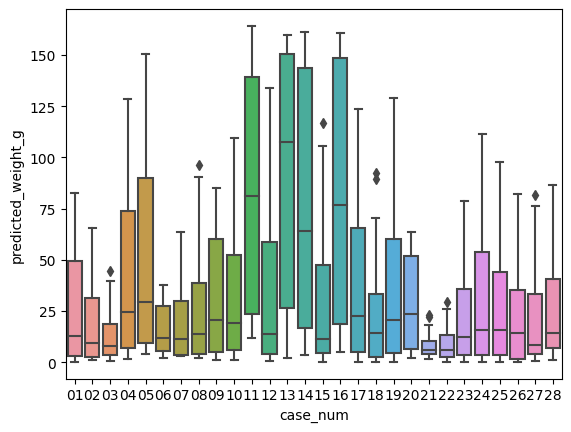

In [35]:
sns.boxplot(x=label_df.case_num,y=label_df.predicted_weight_g)

# 참조용

In [36]:
# https://github.com/cure-lab/SCINet
# https://github.com/fd17/SciNet_PyTorch/blob/master/models.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class SciNet(nn.Module):
	def __init__(self, input_dim, output_dim, latent_dim, layer_dim):
		"""Initialize SciNet Model.
		
		Params
		======
			input_dim (int): number of inputs
			output_dim (int): number of outputs
			latent_dim (int): number of latent neurons
			Layer_dim (int): number of neurons in hidden layers
		"""
		super(SciNet, self).__init__()
		self.latent_dim = latent_dim
		self.enc1 = nn.Linear(input_dim, layer_dim)
		self.enc2 = nn.Linear(layer_dim, layer_dim)
		self.latent = nn.Linear(layer_dim, latent_dim*2)
		self.dec1 = nn.Linear(latent_dim+1, layer_dim)
		self.dec2 = nn.Linear(layer_dim,layer_dim)
		self.out = nn.Linear(layer_dim, output_dim)       
	  
	def encoder(self, x):
		z = F.elu(self.enc1(x))
		z = F.elu(self.enc2(z))
		z = self.latent(z)
		self.mu = z[:, 0:self.latent_dim]
		self.log_sigma = z[:, self.latent_dim:]
		self.sigma = torch.exp(self.log_sigma)        

		# Use reparametrization trick to sample from gaussian
		eps = torch.randn(x.size(0), self.latent_dim)
		z_sample = self.mu + self.sigma * eps        

		# Compute KL loss
		self.kl_loss = kl_divergence(self.mu, self.log_sigma, dim=self.latent_dim)

		return z_sample
	
	def decoder(self, z):
		x = F.elu(self.dec1(z))
		x = F.elu(self.dec2(x))        
		return self.out(x)

	def forward(self, obs):
		q = obs[:,-1].reshape(obs.size(0),1)
		obs = obs[:,0:-1]
		self.latent_r = self.encoder(obs) 
		dec_input = torch.cat( (q, self.latent_r), 1)

		return self.decoder(dec_input)


def kl_divergence(means, log_sigma, dim, target_sigma=0.1):
	"""
	Computes Kullback–Leibler divergence for arrays of mean and log(sigma)
	"""
	target_sigma = torch.Tensor([target_sigma])
	return 1 / 2. * torch.mean(torch.mean(1 / target_sigma**2 * means**2 +
			torch.exp(2 * log_sigma) / target_sigma**2 - 2 * log_sigma + 2 * torch.log(target_sigma), dim=1) - dim)

In [37]:
import numpy as np
import torch

def pendulum(t, A0, delta0, k, b, m):
	"""
	Solution x(t) for pendulum differential equation
		mx'' = -kx + bx'
	Returns position at time t
	Parameters:
		- t: time
		- A0: starting amplitude
		- delta0: phase
		- k: spring constant
		- b: damping factor
	"""
	A = 1 - b**2 / (4 * m * k)
	if A < 0:
		return None
	w = np.sqrt(k/m)* np.sqrt(A)
	result = A0 * np.exp( - t * b / (2. * m) ) * np.cos(w * t + delta0)
	return result

def target_loss(pred,answer):
	"""
	
	"""
	pred = pred[:,0]
	
	return torch.mean(torch.sum((pred - answer)**2), dim=0)

In [38]:
scinet = SciNet(input_dim=X_train.shape[1], output_dim=1, latent_dim=3, layer_dim=64)
scinet

SciNet(
  (enc1): Linear(in_features=121, out_features=64, bias=True)
  (enc2): Linear(in_features=64, out_features=64, bias=True)
  (latent): Linear(in_features=64, out_features=6, bias=True)
  (dec1): Linear(in_features=4, out_features=64, bias=True)
  (dec2): Linear(in_features=64, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=1, bias=True)
)

In [39]:
N_EPOCHS = 100
optimizer = optim.Adam(scinet.parameters())
hist_error = []
hist_loss = []
beta = 0.5

# Training loop
for epoch in range(N_EPOCHS):  
    epoch_error = []
    epoch_loss = []
    for i_batch, minibatch in enumerate(train_loader):

        inputs, outputs = minibatch
        optimizer.zero_grad()
        pred = scinet.forward(inputs)
        
        loss = target_loss(pred, outputs) + beta * scinet.kl_loss
        loss.backward()
        optimizer.step()
        error = torch.mean(torch.sqrt((pred[:,0]-outputs)**2)).detach().numpy()
        epoch_error.append(error)
        epoch_loss.append(loss.data.detach().numpy())
    hist_error.append(np.mean(epoch_error))
    hist_loss.append(np.mean(epoch_loss))
    print("Epoch %d -- loss %f, RMS error %f " % (epoch+1, hist_loss[-1], hist_error[-1]))

NameError: name 'train_loader' is not defined

In [ ]:
# # input_size = [np.array(x[0]).shape for x in train_loader][0][2]
# model = BaseModel(
#     input_size = X_train.shape[1],
#     hidden_sizes=[32,16],
#     dropout_rates=[0.2,0.2],
#     num_classes=1,
#     num_layers=1,
#     bidirectional=False,
# )
# # model = GRUModel(input_dim=X_train.shape[1], hidden_dim=64, layer_dim=1, output_dim=1)

# model.eval()
# optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-6)# lr = CFG["LEARNING_RATE"], weight_decay=1e-5)
# # optimizer = torch.optim.SGD(params = model.parameters(), lr = 1e-4, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.5, patience=2, threshold_mode='abs',min_lr=1e-8, verbose=False)

# best_model = train(
#     model,
#     optimizer=optimizer,
#     train_loader=train_loader,
#     valid_loader=valid_loader,
#     scheduler=scheduler,
#     device=device,
#     early_stopping=False,
#     metric_period=1,
#     epochs=1024,
# )

# test_df = test_df[X_train.columns]
# test_dataset = CustomTestDataset(input=test_df)
# test_loader  = DataLoader(test_dataset, shuffle=False, num_workers=0)

# model.to(device)
# model.eval()
# test_pred = []
# with torch.no_grad():
#     for X in iter(test_loader):
#         X = X.float().to(device)

#         model_pred = model(X)
#         # model_pred = torch.exp(model_pred)
#         model_pred = model_pred.cpu().numpy().reshape(-1).tolist()

#         test_pred += model_pred

In [ ]:
for name, param in model.named_parameters():
    print(name, param.grad.abs().sum())

In [ ]:
test_df['predicted_weight_g'] = test_pred
test_df.head()

<br></br>
GRU

In [ ]:
import math

class GRUCell(nn.Module) :
    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size,  3*hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 3*hidden_size, bias=bias)
        self.reset_parameters()
        
    def reset_parameters(self) :
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters() : 
            w.data.uniform_(-std, std)
            
    def forward(self, x, hidden) : 
        x = x.view(-1, x.size(1))
        
        gate_x = self.x2h(x)
        gate_h = self.h2h(hidden)
        
        gate_x = gate_x.squeeze()
        gate_h = gate_h.squeeze()
        
        i_r, i_i, i_n = gate_x.chunk(3, 1)
        h_r, h_i, h_n = gate_h.chunk(3, 1)
        
        resetgate = F.sigmoid(i_r + h_r)
        inputgate = F.sigmoid(i_i + h_i)
        newgate = F.tanh(i_n + (resetgate * h_n))
        
        hy = newgate + inputgate * (hidden - newgate)
        return hy
    
class GRUModel(nn.Module) :
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True) :
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.gru_cell = GRUCell(input_dim, hidden_dim, layer_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x) :
        if torch.cuda.is_available() :
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
        else :
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
            
        outs = []
        hn = h0[0, :, :]
        
        for seq in range(x.size(1)) : 
            hn = self.gru_cell(x[:, seq, :], hn)
            outs.append(hn)
        out = outs[-1].squeeze()
        out = self.fc(out)
        return out

<br></br>

# 모델링

In [40]:
class CustomDataset(Dataset):
    def __init__(self,input,label,infer_mode,seq_length):
        self.infer_mode = infer_mode
        
        input = input.sort_values(['case_num','DAT'])
        label = label.sort_values(['case_num','DAT'])

        self.input_list = []
        self.label_list = []
        for i in range(int(label.shape[0]/seq_length)):
            i_df = input.iloc[i*seq_length:(i+1)*seq_length,:].drop('case_num',axis=1)
            l_df = label.iloc[i*seq_length:(i+1)*seq_length]['predicted_weight_g']
            self.input_list.append(torch.Tensor(i_df.values))
            self.label_list.append(torch.Tensor(l_df.values))

    def __getitem__(self, index):
        data  = self.input_list[index]
        label = self.label_list[index]
        if self.infer_mode == False:
            return data, label
        else:
            return data

    def __len__(self):
        return len(self.input_list)

In [68]:
seq_length = 2
batch_size = 16
num_workers = 0

train_dataset = CustomDataset(input=X_train, label=y_train, infer_mode=False, seq_length=seq_length)
train_loader  = DataLoader(train_dataset, batch_size = batch_size, shuffle=False, num_workers=num_workers) # CFG['BATCH_SIZE']

valid_dataset = CustomDataset(input=X_valid, label=y_valid, infer_mode=False, seq_length=seq_length)
valid_loader  = DataLoader(valid_dataset, batch_size = batch_size, shuffle=False, num_workers=num_workers) # CFG['BATCH_SIZE']

test_dataset = CustomDataset(input=test_input_df, label=test_label_df, infer_mode=True, seq_length=seq_length)
test_loader  = DataLoader(test_dataset  , batch_size = batch_size, shuffle=False, num_workers=num_workers) # CFG['BATCH_SIZE']

In [69]:
y_train.shape

(728, 3)

In [70]:
# [(x.size(),y.size()) for x,y in iter(train_loader)]
# [y for x,y in iter(train_loader)]
sum([y.size(0) for x,y in iter(train_loader)])

364

In [71]:
len([x for x,y in iter(train_loader)])

23

In [72]:
[(x[0].size(),x[1].size()) for x in train_loader]

[(torch.Size([16, 2, 120]), torch.Size([16, 2])),
 (torch.Size([16, 2, 120]), torch.Size([16, 2])),
 (torch.Size([16, 2, 120]), torch.Size([16, 2])),
 (torch.Size([16, 2, 120]), torch.Size([16, 2])),
 (torch.Size([16, 2, 120]), torch.Size([16, 2])),
 (torch.Size([16, 2, 120]), torch.Size([16, 2])),
 (torch.Size([16, 2, 120]), torch.Size([16, 2])),
 (torch.Size([16, 2, 120]), torch.Size([16, 2])),
 (torch.Size([16, 2, 120]), torch.Size([16, 2])),
 (torch.Size([16, 2, 120]), torch.Size([16, 2])),
 (torch.Size([16, 2, 120]), torch.Size([16, 2])),
 (torch.Size([16, 2, 120]), torch.Size([16, 2])),
 (torch.Size([16, 2, 120]), torch.Size([16, 2])),
 (torch.Size([16, 2, 120]), torch.Size([16, 2])),
 (torch.Size([16, 2, 120]), torch.Size([16, 2])),
 (torch.Size([16, 2, 120]), torch.Size([16, 2])),
 (torch.Size([16, 2, 120]), torch.Size([16, 2])),
 (torch.Size([16, 2, 120]), torch.Size([16, 2])),
 (torch.Size([16, 2, 120]), torch.Size([16, 2])),
 (torch.Size([16, 2, 120]), torch.Size([16, 2])),


In [46]:
# https://www.kaggle.com/code/junkoda/pytorch-lstm-with-tensorflow-like-initialization
class Model(nn.Module):
    def __init__(self, input_size):
        hidden  = [100, 100, 100, 100]
        # dropout = [0.5, 0.5, 0.5, 0.5]
        dropout = [0.2, 0.2, 0.2, 0.2]
        num_layers = [1,1,1,1]
        bidirectional = False
        if bidirectional:
            offset = 2
        else:
            offset = 1
        
        super().__init__()
        
        self.lstm1 = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden[0],
            dropout=dropout[0],
            num_layers=num_layers[0],
            batch_first=True,
            bidirectional=bidirectional,
        )
        self.lstm2 = nn.LSTM(
            input_size=offset*hidden[0],
            hidden_size=hidden[1],
            dropout=dropout[1],
            num_layers=num_layers[1],
            batch_first=True,
            bidirectional=bidirectional,
        )
        self.lstm3 = nn.LSTM(
            input_size=offset*hidden[1],
            hidden_size=hidden[2],
            dropout=dropout[2],
            num_layers=num_layers[2],
            batch_first=True,
            bidirectional=bidirectional,
        )
        self.lstm4 = nn.LSTM(
            input_size=offset*hidden[2],
            hidden_size=hidden[3],
            dropout=dropout[3],
            num_layers=num_layers[3],
            batch_first=True,
            bidirectional=bidirectional,
        )
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.01, inplace=True)
        self.selu = nn.SELU()
        self.bn = nn.BatchNorm1d(24)
        
        self.fc = nn.Linear(offset * hidden[3], 1)
        self.fc = TimeDistributed(self.fc)
        self._reinitialize()
        
    def _reinitialize(self):
        """
        Tensorflow/Keras-like initialization
        """
        for name, p in self.named_parameters():
            if 'lstm' in name:
                if 'weight_ih' in name:
                    nn.init.xavier_uniform_(p.data)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(p.data)
                elif 'bias_ih' in name:
                    p.data.fill_(0)
                    # Set forget-gate bias to 1
                    n = p.size(0)
                    p.data[(n // 4):(n // 2)].fill_(1)
                elif 'bias_hh' in name:
                    p.data.fill_(0)
            elif 'fc' in name:
                if 'weight' in name:
                    nn.init.xavier_uniform_(p.data)
                elif 'bias' in name:
                    p.data.fill_(0)

    def forward(self, x):
        # 1st
        x, _ = self.lstm1(x)
        # x    = self.bn(x)
        x    = self.leakyrelu(x)
        # 2nd
        x, _ = self.lstm2(x)
        # x    = self.bn(x)
        x    = self.leakyrelu(x)
        # 3rd
        x, _ = self.lstm3(x)
        # x    = self.bn(x)
        x    = self.leakyrelu(x)
        # 4th
        x, _ = self.lstm4(x)
        # x    = self.bn(x)
        x    = self.leakyrelu(x)
        # fully connected layer
        x    = self.fc(x[:,-1,:])
        return x

In [47]:
class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)
        # print(x.shape,x_reshape.shape)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y

In [48]:
import math
import torch.nn.functional as F
from torch.autograd import Variable
from torch import nn
import torch
import argparse
import numpy as np

class Splitting(nn.Module):
    def __init__(self):
        super(Splitting, self).__init__()

    def even(self, x):
        return x[:, ::2, :]

    def odd(self, x):
        return x[:, 1::2, :]

    def forward(self, x):
        '''Returns the odd and even part'''
        return (self.even(x), self.odd(x))


class Interactor(nn.Module):
    def __init__(self, in_planes, splitting=True,
                 kernel = 5, dropout=0.5, groups = 1, hidden_size = 1, INN = True):
        super(Interactor, self).__init__()
        self.modified = INN
        self.kernel_size = kernel
        self.dilation = 1
        self.dropout = dropout
        self.hidden_size = hidden_size
        self.groups = groups
        if self.kernel_size % 2 == 0:
            pad_l = self.dilation * (self.kernel_size - 2) // 2 + 1 #by default: stride==1 
            pad_r = self.dilation * (self.kernel_size) // 2 + 1 #by default: stride==1 

        else:
            pad_l = self.dilation * (self.kernel_size - 1) // 2 + 1 # we fix the kernel size of the second layer as 3.
            pad_r = self.dilation * (self.kernel_size - 1) // 2 + 1
        self.splitting = splitting
        self.split = Splitting()

        modules_P = []
        modules_U = []
        modules_psi = []
        modules_phi = []
        prev_size = 1

        size_hidden = self.hidden_size
        modules_P += [
            nn.ReplicationPad1d((pad_l, pad_r)),

            nn.Conv1d(in_planes * prev_size, int(in_planes * size_hidden),
                      kernel_size=self.kernel_size, dilation=self.dilation, stride=1, groups= self.groups),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),

            nn.Dropout(self.dropout),
            nn.Conv1d(int(in_planes * size_hidden), in_planes,
                      kernel_size=3, stride=1, groups= self.groups),
            nn.Tanh()
        ]
        modules_U += [
            nn.ReplicationPad1d((pad_l, pad_r)),
            nn.Conv1d(in_planes * prev_size, int(in_planes * size_hidden),
                      kernel_size=self.kernel_size, dilation=self.dilation, stride=1, groups= self.groups),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(int(in_planes * size_hidden), in_planes,
                      kernel_size=3, stride=1, groups= self.groups),
            nn.Tanh()
        ]

        modules_phi += [
            nn.ReplicationPad1d((pad_l, pad_r)),
            nn.Conv1d(in_planes * prev_size, int(in_planes * size_hidden),
                      kernel_size=self.kernel_size, dilation=self.dilation, stride=1, groups= self.groups),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(int(in_planes * size_hidden), in_planes,
                      kernel_size=3, stride=1, groups= self.groups),
            nn.Tanh()
        ]
        modules_psi += [
            nn.ReplicationPad1d((pad_l, pad_r)),
            nn.Conv1d(in_planes * prev_size, int(in_planes * size_hidden),
                      kernel_size=self.kernel_size, dilation=self.dilation, stride=1, groups= self.groups),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(int(in_planes * size_hidden), in_planes,
                      kernel_size=3, stride=1, groups= self.groups),
            nn.Tanh()
        ]
        self.phi = nn.Sequential(*modules_phi)
        self.psi = nn.Sequential(*modules_psi)
        self.P = nn.Sequential(*modules_P)
        self.U = nn.Sequential(*modules_U)

    def forward(self, x):
        if self.splitting:
            (x_even, x_odd) = self.split(x)
        else:
            (x_even, x_odd) = x

        if self.modified:
            x_even = x_even.permute(0, 2, 1)
            x_odd = x_odd.permute(0, 2, 1)

            d = x_odd.mul(torch.exp(self.phi(x_even)))
            c = x_even.mul(torch.exp(self.psi(x_odd)))

            x_even_update = c + self.U(d)
            x_odd_update = d - self.P(c)

            return (x_even_update, x_odd_update)

        else:
            x_even = x_even.permute(0, 2, 1)
            x_odd = x_odd.permute(0, 2, 1)

            d = x_odd - self.P(x_even)
            c = x_even + self.U(d)

            return (c, d)


class InteractorLevel(nn.Module):
    def __init__(self, in_planes, kernel, dropout, groups , hidden_size, INN):
        super(InteractorLevel, self).__init__()
        self.level = Interactor(in_planes = in_planes, splitting=True,
                 kernel = kernel, dropout=dropout, groups = groups, hidden_size = hidden_size, INN = INN)

    def forward(self, x):
        (x_even_update, x_odd_update) = self.level(x)
        return (x_even_update, x_odd_update)

class LevelSCINet(nn.Module):
    def __init__(self,in_planes, kernel_size, dropout, groups, hidden_size, INN):
        super(LevelSCINet, self).__init__()
        self.interact = InteractorLevel(in_planes= in_planes, kernel = kernel_size, dropout = dropout, groups =groups , hidden_size = hidden_size, INN = INN)

    def forward(self, x):
        (x_even_update, x_odd_update) = self.interact(x)
        return x_even_update.permute(0, 2, 1), x_odd_update.permute(0, 2, 1) #even: B, T, D odd: B, T, D

class SCINet_Tree(nn.Module):
    def __init__(self, in_planes, current_level, kernel_size, dropout, groups, hidden_size, INN):
        super().__init__()
        self.current_level = current_level


        self.workingblock = LevelSCINet(
            in_planes = in_planes,
            kernel_size = kernel_size,
            dropout = dropout,
            groups= groups,
            hidden_size = hidden_size,
            INN = INN)


        if current_level!=0:
            self.SCINet_Tree_odd =SCINet_Tree(in_planes, current_level-1, kernel_size, dropout, groups, hidden_size, INN)
            self.SCINet_Tree_even=SCINet_Tree(in_planes, current_level-1, kernel_size, dropout, groups, hidden_size, INN)
    
    def zip_up_the_pants(self, even, odd):
        even = even.permute(1, 0, 2)
        odd = odd.permute(1, 0, 2) #L, B, D
        even_len = even.shape[0]
        odd_len = odd.shape[0]
        mlen = min((odd_len, even_len))
        _ = []
        for i in range(mlen):
            _.append(even[i].unsqueeze(0))
            _.append(odd[i].unsqueeze(0))
        if odd_len < even_len: 
            _.append(even[-1].unsqueeze(0))
        return torch.cat(_,0).permute(1,0,2) #B, L, D
        
    def forward(self, x):
        x_even_update, x_odd_update= self.workingblock(x)
        # We recursively reordered these sub-series. You can run the ./utils/recursive_demo.py to emulate this procedure. 
        if self.current_level ==0:
            return self.zip_up_the_pants(x_even_update, x_odd_update)
        else:
            return self.zip_up_the_pants(self.SCINet_Tree_even(x_even_update), self.SCINet_Tree_odd(x_odd_update))

class EncoderTree(nn.Module):
    def __init__(self, in_planes,  num_levels, kernel_size, dropout, groups, hidden_size, INN):
        super().__init__()
        self.levels=num_levels
        self.SCINet_Tree = SCINet_Tree(
            in_planes = in_planes,
            current_level = num_levels-1,
            kernel_size = kernel_size,
            dropout =dropout ,
            groups = groups,
            hidden_size = hidden_size,
            INN = INN)
        
    def forward(self, x):

        x= self.SCINet_Tree(x)

        return x

class SCINet(nn.Module):
    def __init__(self, output_len, input_len, input_dim = 9, hid_size = 1, num_stacks = 1,
                num_levels = 3, num_decoder_layer = 1, concat_len = 0, groups = 1, kernel = 5, dropout = 0.5,
                 single_step_output_One = 0, input_len_seg = 0, positionalE = False, modified = True, RIN=False):
        super(SCINet, self).__init__()

        self.input_dim = input_dim
        self.input_len = input_len
        self.output_len = output_len
        self.hidden_size = hid_size
        self.num_levels = num_levels
        self.groups = groups
        self.modified = modified
        self.kernel_size = kernel
        self.dropout = dropout
        self.single_step_output_One = single_step_output_One
        self.concat_len = concat_len
        self.pe = positionalE
        self.RIN=RIN
        self.num_decoder_layer = num_decoder_layer

        self.blocks1 = EncoderTree(
            in_planes=self.input_dim,
            num_levels = self.num_levels,
            kernel_size = self.kernel_size,
            dropout = self.dropout,
            groups = self.groups,
            hidden_size = self.hidden_size,
            INN =  modified)

        if num_stacks == 2: # we only implement two stacks at most.
            self.blocks2 = EncoderTree(
                in_planes=self.input_dim,
            num_levels = self.num_levels,
            kernel_size = self.kernel_size,
            dropout = self.dropout,
            groups = self.groups,
            hidden_size = self.hidden_size,
            INN =  modified)

        self.stacks = num_stacks

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
        self.projection1 = nn.Conv1d(self.input_len, self.output_len, kernel_size=1, stride=1, bias=False)
        self.div_projection = nn.ModuleList()
        self.overlap_len = self.input_len//4
        self.div_len = self.input_len//6

        if self.num_decoder_layer > 1:
            self.projection1 = nn.Linear(self.input_len, self.output_len)
            for layer_idx in range(self.num_decoder_layer-1):
                div_projection = nn.ModuleList()
                for i in range(6):
                    lens = min(i*self.div_len+self.overlap_len,self.input_len) - i*self.div_len
                    div_projection.append(nn.Linear(lens, self.div_len))
                self.div_projection.append(div_projection)

        if self.single_step_output_One: # only output the N_th timestep.
            if self.stacks == 2:
                if self.concat_len:
                    self.projection2 = nn.Conv1d(self.concat_len + self.output_len, 1,
                                                kernel_size = 1, bias = False)
                else:
                    self.projection2 = nn.Conv1d(self.input_len + self.output_len, 1,
                                                kernel_size = 1, bias = False)
        else: # output the N timesteps.
            if self.stacks == 2:
                if self.concat_len:
                    self.projection2 = nn.Conv1d(self.concat_len + self.output_len, self.output_len,
                                                kernel_size = 1, bias = False)
                else:
                    self.projection2 = nn.Conv1d(self.input_len + self.output_len, self.output_len,
                                                kernel_size = 1, bias = False)

        # For positional encoding
        self.pe_hidden_size = input_dim
        if self.pe_hidden_size % 2 == 1:
            self.pe_hidden_size += 1
    
        num_timescales = self.pe_hidden_size // 2
        max_timescale = 10000.0
        min_timescale = 1.0

        log_timescale_increment = (
                math.log(float(max_timescale) / float(min_timescale)) /
                max(num_timescales - 1, 1))
        temp = torch.arange(num_timescales, dtype=torch.float32)
        inv_timescales = min_timescale * torch.exp(
            torch.arange(num_timescales, dtype=torch.float32) *
            -log_timescale_increment)
        self.register_buffer('inv_timescales', inv_timescales)

        ### RIN Parameters ###
        if self.RIN:
            self.affine_weight = nn.Parameter(torch.ones(1, 1, input_dim))
            self.affine_bias = nn.Parameter(torch.zeros(1, 1, input_dim))
    
    def get_position_encoding(self, x):
        max_length = x.size()[1]
        position = torch.arange(max_length, dtype=torch.float32, device=x.device)  # tensor([0., 1., 2., 3., 4.], device='cuda:0')
        temp1 = position.unsqueeze(1)  # 5 1
        temp2 = self.inv_timescales.unsqueeze(0)  # 1 256
        scaled_time = position.unsqueeze(1) * self.inv_timescales.unsqueeze(0)  # 5 256
        signal = torch.cat([torch.sin(scaled_time), torch.cos(scaled_time)], dim=1)  #[T, C]
        signal = F.pad(signal, (0, 0, 0, self.pe_hidden_size % 2))
        signal = signal.view(1, max_length, self.pe_hidden_size)
    
        return signal

    def forward(self, x):
        assert self.input_len % (np.power(2, self.num_levels)) == 0 # evenly divided the input length into two parts. (e.g., 32 -> 16 -> 8 -> 4 for 3 levels)
        if self.pe:
            pe = self.get_position_encoding(x)
            if pe.shape[2] > x.shape[2]:
                x += pe[:, :, :-1]
            else:
                x += self.get_position_encoding(x)

        ### activated when RIN flag is set ###
        if self.RIN:
            print('/// RIN ACTIVATED ///\r',end='')
            means = x.mean(1, keepdim=True).detach()
            #mean
            x = x - means
            #var
            stdev = torch.sqrt(torch.var(x, dim=1, keepdim=True, unbiased=False) + 1e-5)
            x /= stdev
            # affine
            # print(x.shape,self.affine_weight.shape,self.affine_bias.shape)
            x = x * self.affine_weight + self.affine_bias

        # the first stack
        res1 = x
        x = self.blocks1(x)
        x += res1
        if self.num_decoder_layer == 1:
            x = self.projection1(x)
        else:
            x = x.permute(0,2,1)
            for div_projection in self.div_projection:
                output = torch.zeros(x.shape,dtype=x.dtype).cuda()
                for i, div_layer in enumerate(div_projection):
                    div_x = x[:,:,i*self.div_len:min(i*self.div_len+self.overlap_len,self.input_len)]
                    output[:,:,i*self.div_len:(i+1)*self.div_len] = div_layer(div_x)
                x = output
            x = self.projection1(x)
            x = x.permute(0,2,1)

        if self.stacks == 1:
            ### reverse RIN ###
            if self.RIN:
                x = x - self.affine_bias
                x = x / (self.affine_weight + 1e-10)
                x = x * stdev
                x = x + means

            return x

        elif self.stacks == 2:
            MidOutPut = x
            if self.concat_len:
                x = torch.cat((res1[:, -self.concat_len:,:], x), dim=1)
            else:
                x = torch.cat((res1, x), dim=1)

            # the second stack
            res2 = x
            x = self.blocks2(x)
            x += res2
            x = self.projection2(x)
            
            ### Reverse RIN ###
            if self.RIN:
                MidOutPut = MidOutPut - self.affine_bias
                MidOutPut = MidOutPut / (self.affine_weight + 1e-10)
                MidOutPut = MidOutPut * stdev
                MidOutPut = MidOutPut + means

            if self.RIN:
                x = x - self.affine_bias
                x = x / (self.affine_weight + 1e-10)
                x = x * stdev
                x = x + means

            return x, MidOutPut

def get_variable(x):
    x = Variable(x)
    return x.cuda() if torch.cuda.is_available() else x

In [49]:
import math
import torch.nn.functional as F
from torch.autograd import Variable
from torch import nn
import torch
import argparse
import numpy as np

class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class SCINet_decompose(nn.Module):
    def __init__(self, output_len, input_len, input_dim = 9, hid_size = 1, num_stacks = 1,
                num_levels = 3, concat_len = 0, groups = 1, kernel = 5, dropout = 0.5,
                 single_step_output_One = 0, input_len_seg = 0, positionalE = False, modified = True, RIN=False):
        super(SCINet_decompose, self).__init__()

        self.input_dim = input_dim
        self.input_len = input_len
        self.output_len = output_len
        self.hidden_size = hid_size
        self.num_levels = num_levels
        self.groups = groups
        self.modified = modified
        self.kernel_size = kernel
        self.dropout = dropout
        self.single_step_output_One = single_step_output_One
        self.concat_len = concat_len
        self.pe = positionalE
        self.RIN=RIN
        self.decomp = series_decomp(25)
        self.trend = nn.Linear(input_len,input_len)
        self.trend_dec = nn.Linear(input_len,output_len)
        self.blocks1 = EncoderTree(
            in_planes=self.input_dim,
            num_levels = self.num_levels,
            kernel_size = self.kernel_size,
            dropout = self.dropout,
            groups = self.groups,
            hidden_size = self.hidden_size,
            INN =  modified)

        if num_stacks == 2: # we only implement two stacks at most.
            self.blocks2 = EncoderTree(
                in_planes=self.input_dim,
            num_levels = self.num_levels,
            kernel_size = self.kernel_size,
            dropout = self.dropout,
            groups = self.groups,
            hidden_size = self.hidden_size,
            INN =  modified)

        self.stacks = num_stacks

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
        self.projection1 = nn.Conv1d(self.input_len, self.output_len, kernel_size=1, stride=1, bias=False)
        if self.single_step_output_One: # only output the N_th timestep.
            if self.stacks == 2:
                if self.concat_len:
                    self.projection2 = nn.Conv1d(self.concat_len + self.output_len, 1,
                                                kernel_size = 1, bias = False)
                else:
                    self.projection2 = nn.Conv1d(self.input_len + self.output_len, 1,
                                                kernel_size = 1, bias = False)
        else: # output the N timesteps.
            if self.stacks == 2:
                if self.concat_len:
                    self.projection2 = nn.Conv1d(self.concat_len + self.output_len, self.output_len,
                                                kernel_size = 1, bias = False)
                else:
                    self.projection2 = nn.Conv1d(self.input_len + self.output_len, self.output_len,
                                                kernel_size = 1, bias = False)

        # For positional encoding
        self.pe_hidden_size = input_dim
        if self.pe_hidden_size % 2 == 1:
            self.pe_hidden_size += 1
    
        num_timescales = self.pe_hidden_size // 2
        max_timescale = 10000.0
        min_timescale = 1.0

        log_timescale_increment = (
                math.log(float(max_timescale) / float(min_timescale)) /
                max(num_timescales - 1, 1))
        temp = torch.arange(num_timescales, dtype=torch.float32)
        inv_timescales = min_timescale * torch.exp(
            torch.arange(num_timescales, dtype=torch.float32) *
            -log_timescale_increment)
        self.register_buffer('inv_timescales', inv_timescales)

        ### RIN Parameters ###
        if self.RIN:
            self.affine_weight = nn.Parameter(torch.ones(1, 1, input_dim))
            self.affine_bias = nn.Parameter(torch.zeros(1, 1, input_dim))
            self.affine_weight2 = nn.Parameter(torch.ones(1, 1, input_dim))
            self.affine_bias2 = nn.Parameter(torch.zeros(1, 1, input_dim))
    
    def get_position_encoding(self, x):
        max_length = x.size()[1]
        position = torch.arange(max_length, dtype=torch.float32, device=x.device)  # tensor([0., 1., 2., 3., 4.], device='cuda:0')
        temp1 = position.unsqueeze(1)  # 5 1
        temp2 = self.inv_timescales.unsqueeze(0)  # 1 256
        scaled_time = position.unsqueeze(1) * self.inv_timescales.unsqueeze(0)  # 5 256
        signal = torch.cat([torch.sin(scaled_time), torch.cos(scaled_time)], dim=1)  #[T, C]
        signal = F.pad(signal, (0, 0, 0, self.pe_hidden_size % 2))
        signal = signal.view(1, max_length, self.pe_hidden_size)
    
        return signal

    def forward(self, x):
        assert self.input_len % (np.power(2, self.num_levels)) == 0 # evenly divided the input length into two parts. (e.g., 32 -> 16 -> 8 -> 4 for 3 levels)
        x, trend = self.decomp(x)

        if self.RIN:
            means = x.mean(1, keepdim=True).detach()
            x = x - means
            stdev = torch.sqrt(torch.var(x, dim=1, keepdim=True, unbiased=False) + 1e-5)
            x /= stdev
            # seq_means = x[:,-1,:].unsqueeze(1).repeat(1,self.input_len,1).detach()
            # pred_means = x[:,-1,:].unsqueeze(1).repeat(1,self.output_len,1).detach()
            # x = x - seq_means
            x = x * self.affine_weight + self.affine_bias

            # print('/// RIN ACTIVATED ///\r',end='')
            means2 = trend.mean(1, keepdim=True).detach()
            trend = trend - means2
            stdev2 = torch.sqrt(torch.var(trend, dim=1, keepdim=True, unbiased=False) + 1e-5)
            trend /= stdev2
            # seq_means2 = trend[:,-1,:].unsqueeze(1).repeat(1,self.input_len,1).detach()
            # pred_means2 = trend[:,-1,:].unsqueeze(1).repeat(1,self.output_len,1).detach()
            # trend = trend - seq_means2 
            trend = trend * self.affine_weight2 + self.affine_bias2
        

        if self.pe:
            pe = self.get_position_encoding(x)
            if pe.shape[2] > x.shape[2]:
                x = x + pe[:, :, :-1]
            else:
                x = x + self.get_position_encoding(x)

        ### activated when RIN flag is set ###
        

        # the first stack
        res1 = x
        x = self.blocks1(x)
        x = self.projection1(x)

        trend = trend.permute(0,2,1)
        trend = self.trend(trend)  
        trend = self.trend_dec(trend).permute(0,2,1)

        if self.stacks == 1:
            ### reverse RIN ###
            if self.RIN:
                x = x - self.affine_bias
                x = x / (self.affine_weight + 1e-10)
                # x = x + pred_means
                x = x * stdev
                x = x + means

                trend = trend - self.affine_bias2
                trend = trend / (self.affine_weight2 + 1e-10)
                # trend = trend + pred_means2
                trend = trend * stdev2
                trend = trend + means2

            return x + trend

        elif self.stacks == 2:
            MidOutPut = x
            if self.concat_len:
                x = torch.cat((res1[:, -self.concat_len:,:], x), dim=1)
            else:
                x = torch.cat((res1, x), dim=1)

            # the second stack
            x = self.blocks2(x)
            x = self.projection2(x)
            
            ### Reverse RIN ###
            if self.RIN:
                MidOutPut = MidOutPut - self.affine_bias
                MidOutPut = MidOutPut / (self.affine_weight + 1e-10)
                MidOutPut = MidOutPut * stdev
                MidOutPut = MidOutPut + means

                x = x - self.affine_bias
                x = x / (self.affine_weight + 1e-10)
                x = x * stdev
                x = x + means

                trend = trend - self.affine_bias2
                trend = trend / (self.affine_weight2 + 1e-10)
                # trend = trend + pred_means2
                trend = trend * stdev2
                trend = trend + means2

            return x + trend, MidOutPut


def get_variable(x):
    x = Variable(x)
    return x.cuda() if torch.cuda.is_available() else x

In [50]:
class SCINet_Model(nn.Module):
    def __init__(self,input_size):
        super(SCINet_Model, self).__init__()
        super().__init__()
        
        # 24,4,1,1,2,0.5,False,1,True,1
        window_size = 1 # in (fixed)
        horizon = 1      # out
        hidden_size = 1
        groups = 1
        kernel = 1
        dropout = 0.5
        single_step_output_One = False
        num_levels = 1
        positionalEcoding = True
        num_stacks = 1
        self.scinet = SCINet(
            output_len = horizon, input_len = window_size, input_dim = input_size, hid_size = hidden_size, 
            num_stacks = num_stacks, num_levels = num_levels, concat_len = 0, groups = groups, kernel = kernel, 
            dropout = dropout, single_step_output_One = single_step_output_One, positionalE =  positionalEcoding, 
            modified = True, RIN = True,
        )
        self.scinet_decompose = SCINet_decompose(
            output_len = horizon, input_len = window_size, input_dim = input_size, hid_size = hidden_size, 
            num_stacks = num_stacks, num_levels = num_levels, concat_len = 0, groups = groups, kernel = kernel, 
            dropout = dropout, single_step_output_One = single_step_output_One, positionalE =  positionalEcoding, 
            modified = True, RIN = True,
        )
        
        # hidden  = [64, 64, 64]
        # dropout = [0.2, 0.5, 0.5]
        # num_layers = [1,1,1]
        # self.lstm1 = nn.LSTM(
        #     input_size=input_size,
        #     hidden_size=hidden[0],
        #     dropout=dropout[0],
        #     num_layers=num_layers[0],
        #     batch_first=True,
        #     bidirectional=True,
        # )
        # self.lstm2 = nn.LSTM(
        #     input_size=2*hidden[0],
        #     hidden_size=hidden[1],
        #     dropout=dropout[1],
        #     num_layers=num_layers[1],
        #     batch_first=True,
        #     bidirectional=True,
        # )
        # self.lstm3 = nn.LSTM(
        #     input_size=2*hidden[1],
        #     hidden_size=hidden[2],
        #     dropout=dropout[2],
        #     num_layers=num_layers[2],
        #     batch_first=True,
        #     bidirectional=True,
        # )
        
        self.dropout = nn.Dropout(p=dropout)
        self.bn = nn.BatchNorm1d(24)
        self.relu = nn.ReLU()
        self.selu = nn.SELU()
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.01, inplace=True)
        # self.fc = nn.Linear(2*hidden[0], 1)
        self.fc_1 = nn.Linear(input_size, 16)
        self.fc_1 = TimeDistributed(self.fc_1)
        self.fc_2 = nn.Linear(16, 1)
        self.fc_2 = TimeDistributed(self.fc_2)
        self.fc   = nn.Linear(input_size,1)
        self.fc   = TimeDistributed(self.fc)
        self._reinitialize()

        # for name, p in self.named_parameters():
        #     print(name, 'scinet' in name)
        
    def _reinitialize(self):
        """
        Tensorflow/Keras-like initialization
        """
        for name, p in self.named_parameters():
            if 'lstm' in name:
                if 'weight_ih' in name:
                    nn.init.xavier_uniform_(p.data)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(p.data)
                elif 'bias_ih' in name:
                    p.data.fill_(0)
                    # Set forget-gate bias to 1
                    n = p.size(0)
                    p.data[(n // 4):(n // 2)].fill_(1)
                elif 'bias_hh' in name:
                    p.data.fill_(0)
            elif 'fc' in name:
                if 'weight' in name:
                    nn.init.xavier_uniform_(p.data)
                elif 'bias' in name:
                    p.data.fill_(0)
        
#     def forward(self, x):
#         x = self.scinet(x)
#         # x = self.bn(x)
#         # x = self.relu(x)
#         # x,_ = self.lstm1(x)
#         # x = self.relu(x)
#         # x,_ = self.lstm2(x)
#         # x = self.selu(x)
#         # x,_ = self.lstm3(x)
#         # x = self.selu(x)

#         x = self.fc_1(x)
#         x = self.dropout(x)
#         x = self.leakyrelu(x)
#         x = self.fc_2(x[:,-1,:]) # [:,:,-1]
        
#         # x = self.fc_2(x[:,-1,:])
#         return x

#     def forward(self, x):
#         # x = self.scinet(x)
#         x = self.scinet_decompose(x)
#         x1,x2 = x[0],x[1]
#         x = torch.cat([x1,x2],dim=1)
#         x = self.fc(x[:,-1,:])
        
#         return x
    
    def forward(self, x):
        # x = self.scinet(x)
        x = self.scinet_decompose(x)
        x = self.fc(x[:,-1,:])
        
        return x

In [51]:
# input_size = input_size = [np.array(x[0]).shape for x in train_loader][0][2]
# model = Model(input_size = input_size)

In [52]:
[x[0].shape for x in train_loader][0]

torch.Size([16, 2, 120])

In [53]:
# gc.collect()

In [54]:
seed_everything(CFG['SEED'])

input_size = [np.array(x[0]).shape for x in train_loader][0][2]
model = Model(input_size = input_size)
# model = SCINet_Model(input_size = input_size)
# model = BaseModel(
#     input_size = input_size,
#     hidden_sizes=[400,300],
#     dropout_rates=[0.2,0.2],
#     num_classes=seq_length,
#     num_layers=2,
#     bidirectional=True,
# )

model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-4, weight_decay=1e-5)
# optimizer = torch.optim.SGD(params = model.parameters(), lr = 1e-4, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, threshold_mode='abs',min_lr=1e-7, verbose=False)

CFG['PATIENCE']=100
best_model = train(
    model,
    optimizer=optimizer,
    train_loader=train_loader,
    valid_loader=valid_loader,
    scheduler=None,#scheduler,
    device=device,
    early_stopping=False,
    metric_period=1,
    epochs=1024,
    best_model_only=True,
)

*[0001/1024] tr_loss : 49.01098, val_loss : 32.74091, elapsed : 0.18s, total : 0.18s, remaining : 187.59s
*[0002/1024] tr_loss : 48.99673, val_loss : 32.72286, elapsed : 0.16s, total : 0.35s, remaining : 165.64s
*[0003/1024] tr_loss : 48.97692, val_loss : 32.69406, elapsed : 0.16s, total : 0.50s, remaining : 161.21s
*[0004/1024] tr_loss : 48.94448, val_loss : 32.63502, elapsed : 0.16s, total : 0.66s, remaining : 158.35s
*[0005/1024] tr_loss : 48.87850, val_loss : 32.47966, elapsed : 0.16s, total : 0.82s, remaining : 167.06s
*[0006/1024] tr_loss : 48.70977, val_loss : 32.02017, elapsed : 0.16s, total : 0.98s, remaining : 164.27s
*[0007/1024] tr_loss : 48.23020, val_loss : 30.98006, elapsed : 0.16s, total : 1.14s, remaining : 163.23s
*[0008/1024] tr_loss : 47.20781, val_loss : 29.71524, elapsed : 0.16s, total : 1.30s, remaining : 158.53s
*[0009/1024] tr_loss : 46.00685, val_loss : 28.84282, elapsed : 0.16s, total : 1.46s, remaining : 160.98s
*[0010/1024] tr_loss : 45.10253, val_loss : 28

<br>

Save/Load Model

In [55]:
import datetime
path = f'./model/best_model_999.pt'
# path = f'./model/best_model.pt'

torch.save(best_model.state_dict(), path)

In [57]:
best_model = Model(input_size = input_size) # SCINet_Model
best_model.load_state_dict(torch.load(path, map_location=device))

<All keys matched successfully>

In [58]:
best_model.to(device)
best_model.eval()
pred_list = []
true_list = []
with torch.no_grad():
    for X,y in iter(valid_loader): # train_loader, valid_loader
        X = X.float().to(device)

        model_pred = best_model(X)
        # model_pred = torch.exp(model_pred)
        
        pred_list += model_pred.cpu().numpy().reshape(-1).tolist()
        true_list += y         .cpu().numpy().reshape(-1).tolist()

In [59]:
len([x.shape for x,y in iter(train_dataset)])

364

In [67]:
y_valid.shape

(56, 3)

In [60]:
len([x for x in np.array(pred_list)]),len([x for x in np.array(true_list)])

(28, 56)

In [64]:
for i in range(size): # 3,25

    plot_df = pd.DataFrame({
        'pred' : pred_list,
        'true' : true_list,
    })#[i*28:(i+1)*28]
    plot_df = plot_df.reset_index(drop=True)
    # plot_df = np.exp(plot_df)

    sns.lineplot(x=plot_df.index,y=plot_df.true,color='black')
    sns.lineplot(x=plot_df.index,y=plot_df.pred,color='red')
    # plt.title(random_num[i])
    plt.show()

ValueError: All arrays must be of the same length

In [ ]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(plot_df.pred,plot_df.true))

<br></br>

# Inference

In [ ]:
best_model.to(device)
best_model.eval()
pred_list = []
with torch.no_grad():
    for X in iter(test_loader):
        X = X.float().to(device)

        model_pred = best_model(X)
        # model_pred = torch.exp(model_pred)

        pred_list += model_pred.cpu().numpy().reshape(-1).tolist()

In [ ]:
sub = test_label_df.sort_values(['case_num','DAT'])
sub['predicted_weight_g'] = pred_list

for case_num in sub.case_num.unique():
    s = sub[sub.case_num==case_num].drop('case_num',axis=1)
    s.to_csv(f'./out/lstm/TEST_{case_num}.csv',index=False)

In [ ]:
import zipfile
os.chdir('/home/studio-lab-user/Dacon/6_상추생육환경생성')
os.chdir("./out/lstm/")
submission = zipfile.ZipFile("../lstm.zip", 'w')
for path in all_test_label_list:
    path = path.split('/')[-1]
    submission.write(path)
submission.close()
os.chdir('/home/studio-lab-user/Dacon/6_상추생육환경생성')

<br></br>

In [ ]:
# https://github.com/cure-lab/SCINet/blob/main/models/SCINet.py

In [ ]:
parser = argparse.ArgumentParser()

parser.add_argument('--window_size', type=int, default=96)
parser.add_argument('--horizon', type=int, default=12)

parser.add_argument('--dropout', type=float, default=0.5)
parser.add_argument('--groups', type=int, default=1)

parser.add_argument('--hidden-size', default=1, type=int, help='hidden channel of module')
parser.add_argument('--INN', default=1, type=int, help='use INN or basic strategy')
parser.add_argument('--kernel', default=3, type=int, help='kernel size')
parser.add_argument('--dilation', default=1, type=int, help='dilation')
parser.add_argument('--positionalEcoding', type=bool, default=True)

parser.add_argument('--single_step_output_One', type=int, default=0)

args = parser.parse_args()

In [ ]:
horizon = 12
window_size = 96
hidden_size = 1
groups = 1
kernel = 3
dropout = 0.5
single_step_output_One = 0
positionalEcoding = True

In [ ]:
device = 'cpu'

In [ ]:
model = SCINet(
    output_len = horizon, input_len= window_size, input_dim = 9, hid_size = hidden_size, num_stacks = 1,
    num_levels = 3, concat_len = 0, groups = groups, kernel = kernel, dropout = dropout,
    single_step_output_One = single_step_output_One, positionalE =  positionalEcoding, modified = True
).to(device)
x = torch.randn(32, 96, 9).to(device)
y = model(x)
print(y.shape)

In [ ]:
x.shape, y.shape